In [54]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm


In [55]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Standardize.
    for path in paths_all:
        content = open(path).read()
        content = content.lower()
        for punctuation in ".,:;?!":
            content = content.replace(punctuation, " " + punctuation)
        open(path, "w").write(content)

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

In [56]:
batch_size = 32 # Not for SGD!
seed = 42

def create_dataset(dataset_path):
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size,
        seed=seed
    )
    return dataset

dataset_original_all   = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 20 files.
Found 16 files.
Found 4 files.


In [57]:
for x in dataset_original_all.take(1):
    print(x.shape)
    print(x[0])

(20,)
tf.Tensor(b'the festival\n\nefficiut daemones , ut quae non sunt , sic tamen quasi sint , conspicienda hominibus exhibeant .\n\n--lacantius\n\n(devils so work that things which are not appear to men as if they were real .)\n\ni was far from home , and the spell of the eastern sea was upon me . in the twilight i heard it pounding on the rocks , and i knew it lay just over the hill where the twisting willows writhed against the clearing sky and the first stars of evening . and because my fathers had called me to the old town beyond , i pushed on through the shallow , new-fallen snow along the road that soared lonely up to where aldebaran twinkled among the trees ; on toward the very ancient town i had never seen but often dreamed of .\n\nit was the yuletide , that men call christmas though they know in their hearts it is older than bethlehem and babylon , older than memphis and mankind . it was the yuletide , and i had come at last to the ancient sea town where my people had dwelt 

In [58]:
vocabulary_size = 15_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_original_all)

vocabulary = encoder.get_vocabulary()
print(vocabulary)

['', '[UNK]', 'the', ',', 'of', 'and', '.', 'i', 'to', 'a', 'in', 'was', 'that', 'had', 'my', 'it', 'as', 'with', 'he', 'which', ';', 'at', 'from', 'for', 'not', 'on', 'but', 'were', 'me', 'his', 'by', 'this', 'all', 'have', 'be', 'or', 'they', 'could', 'there', 'one', 'an', 'some', 'no', 'when', 'so', 'what', 'been', 'is', 'its', 'would', 'their', 'them', 'now', 'more', 'him', 'about', 'only', 'out', 'before', 'great', 'seemed', 'did', 'into', 'time', 'than', 'old', 'very', 'any', 'through', 'those', 'though', 'then', 'up', 'after', 'must', 'we', 'saw', 'upon', 'even', 'where', 'things', 'these', 'who', 'man', 'over', 'down', 'if', 'found', 'such', 'other', 'came', 'might', 'strange', '?', 'night', 'like', 'certain', 'much', 'you', 'still', 'thing', 'whose', 'first', 'long', 'most', 'beyond', 'yet', 'black', 'never', 'dreams', 'our', 'once', 'are', 'made', 'knew', 'felt', 'many', 'stone', 'last', 'know', 'heard', 'thought', 'men', 'two', 'told', 'how', 'too', 'ancient', 'back', 'dark'

In [59]:
sequence_length = 32
padding_token_id = 0

def create_dataset_for_autoregression(dataset, hop_length=1):
    x_inputs = []
    y_outputs = []

    for books in dataset:

        books = encoder(books).numpy() # Encodes all books into word indices.

        for book in books:

            # Remove the padding tokens.
            book = [index for index in list(book) if index != padding_token_id]

            for start_index in range(0, len(book) - sequence_length, hop_length):
                x = book[start_index:start_index + sequence_length]
                y = book[start_index + 1: start_index + sequence_length + 1]
                assert len(x) == sequence_length
                assert len(y) == sequence_length

                x_inputs += [x]
                y_outputs += [y]

    return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))


dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

In [60]:
def decode(indices):
    return " ".join([vocabulary[index] for index in indices])

for input, output in dataset_train.take(8):
    print("in: ", decode(input))
    print("out:", decode(output))
    print("")

in:  what the moon brings it was in the spectral summer when the moon shone down on the old garden where i wandered ; the spectral summer of narcotic flowers and humid seas
out: the moon brings it was in the spectral summer when the moon shone down on the old garden where i wandered ; the spectral summer of narcotic flowers and humid seas of

in:  the moon brings it was in the spectral summer when the moon shone down on the old garden where i wandered ; the spectral summer of narcotic flowers and humid seas of
out: moon brings it was in the spectral summer when the moon shone down on the old garden where i wandered ; the spectral summer of narcotic flowers and humid seas of foliage

in:  moon brings it was in the spectral summer when the moon shone down on the old garden where i wandered ; the spectral summer of narcotic flowers and humid seas of foliage
out: brings it was in the spectral summer when the moon shone down on the old garden where i wandered ; the spectral summer of narcot

In [61]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

In [62]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size)) # Like is!
#model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))

model.add(layers.Dropout(0.1)) # Plot twist!
model.add(layers.LSTM(embedding_size, return_sequences=True)) # Plot twist!
model.add(layers.Dropout(0.1)) # Plot twist!
model.add(layers.Dense(vocabulary_size, activation="softmax"))
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", # Important! Computing the error between a predicted prob-dist and the label.
    metrics=["accuracy"]
)

model.fit(
    dataset_train.shuffle(10_000).batch(1024),
    epochs=15, # TODO go up to 10
    validation_data=dataset_valid.batch(1024)
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 706ms/step - accuracy: 0.0587 - loss: 8.4246 - val_accuracy: 0.0557 - val_loss: 7.2374
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 705ms/step - accuracy: 0.0675 - loss: 6.8636 - val_accuracy: 0.0558 - val_loss: 7.3067
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.0676 - loss: 6.8324 - val_accuracy: 0.0558 - val_loss: 7.3416
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 708ms/step - accuracy: 0.0675 - loss: 6.8074 - val_accuracy: 0.0558 - val_loss: 7.2315
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 707ms/step - accuracy: 0.0753 - loss: 6.6668 - val_accuracy: 0.0726 - val_loss: 7.0692
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 707ms/step - accuracy: 0.0930 - loss: 6.4676 - val_accuracy: 0.0873 - val_loss: 7.0029
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 707ms/step - accuracy: 0.1017 - loss: 6.2920 - val_accuracy: 0.0880 - val_loss: 6.9685
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 706ms/step - accuracy: 0.1059 - loss: 6.1649 - val_accu

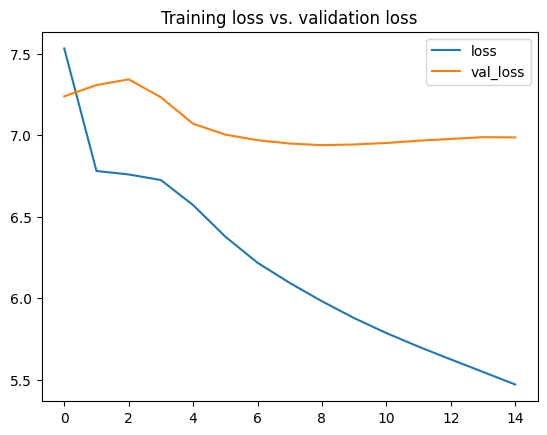

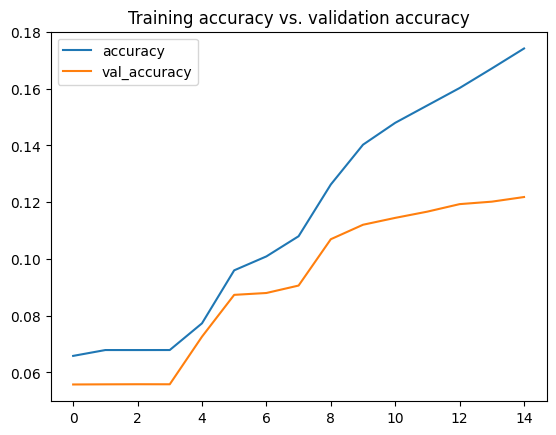

In [63]:
render_history(model.history)

In [66]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)
    print(seed_text)

    input_sequence = encoder(seed_text).numpy().tolist()
    print(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=False)
        #print(prediction.shape)
        #plt.plot(prediction[0][-1])
        #assert False
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, " Who is afraid of air?", 100, temperature=1)

 who is afraid of air ?
[82, 47, 717, 4, 311, 93]
who is afraid of air? his submerged road, for the first foul by the surrounding irresistibly green with two, for the now ascent. this city of the old end, i heard some thrones and was meanwhile a crowning life had no full and eternal intricately named about a queer stone, except they found the side had soon be above him a very haunted when he did say in retrace while the black afternoon agreed ago. they not dream-infested out of space was stewing the door--though gilman thought lately held to mnar his denys

